# Montage Workflow

Montage is a portable software toolkit for constructing custom, science-grade mosaics by composing multiple astronomical images. The mosaics preserve astrometry (source positions) and photometry (source intensities), making them suitable for scientific analysis.

After the workflow is complete, you will find a png file in workflow directory. The png file is a mosaic of the 91 2MASS K-band images centered on M17

In [1]:
import glob
from pandas.core.common import flatten
import parsl
from parsl import python_app, bash_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.providers import CondorProvider
from parsl.executors import HighThroughputExecutor
from parsl.data_provider.file_noop import NoOpFileStaging
from parsl.executors.taskvine import TaskVineExecutor
from parsl.executors.taskvine import TaskVineManagerConfig
from parsl.executors.taskvine import TaskVineFactoryConfig
from concurrent.futures import as_completed
from parsl.data_provider.files import File
from tqdm import tqdm

In [2]:
import os

manager_name = os.environ.get("VINE_MANAGER_NAME")

print(f"Manager name: {manager_name}")

Manager name: floability-ac47e66c-eda6-481c-8444-a2d6405aadff


In [3]:
config = Config(
    executors=[
        TaskVineExecutor(
            manager_config=TaskVineManagerConfig(port=0, project_name=manager_name),
            worker_launch_method="manual",
        ),
    ]
)

In [4]:
# used twice
@bash_app
# def create_input_metadata_table(inputs=[], outputs=[], parsl_resource_specification={"cores":8, "disk":500}):
def create_input_metadata_table(
    inputs=[],
    outputs=[],
    stdout="cimt.stdout",
    stderr="cimt.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mImgtbl . {outputs[0]} -t {inputs[0]}"


@bash_app
# def create_repro_metadata_table(inputs=[], outputs=[]):
def create_repro_metadata_table(
    inputs=[],
    outputs=[],
    stdout="cpromdt.stdout",
    stderr="cpromdt.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mImgtbl . {outputs[0]} -t {inputs[-1]}"


@bash_app
# def create_fits_header(inputs=[],outputs=[]):
def create_fits_header(
    inputs=[],
    outputs=[],
    stdout="cfhdr.stdout",
    stderr="cfhdr.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mMakeHdr {inputs[0]} {outputs[0]}"


@bash_app
# def project_input_images(inputs=[],outputs=[], parsl_resource_specification={"cores":8, "disk":1500}):
def project_input_images(
    inputs=[],
    outputs=[],
    stdout="projii.stdout",
    stderr="projii.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mProjExec {inputs[0]} {inputs[1]} . {outputs[0]}"


@bash_app
# def analyze_overlap(inputs=[],outputs=[]):
def analyze_overlap(
    inputs=[],
    outputs=[],
    stdout="aolap.stdout",
    stderr="aolap.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mOverlaps {inputs[0]} {outputs[0]}"


@bash_app
# def create_diffs(inputs=[],outputs=[], parsl_resource_specification={"cores":8, "disk":1000}):
def create_diffs(
    uid,
    inputs=[],
    outputs=[],
    stdout="cdiff.stdout",
    stderr="cdiff.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mDiffExec -p . {inputs[0]} {inputs[1]} . ; rename diff. {uid}-diff. diff.*"


@bash_app
# def fit_diffs(inputs=[],outputs=[]):
def fit_diffs(
    inputs=[],
    outputs=[],
    stdout="fdiff.stdout",
    stderr="fdiff.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mFitExec {inputs[0]} {outputs[0]} ."


@bash_app
# def compute_corrections(inputs=[],outputs=[]):
def compute_corrections(
    inputs=[],
    outputs=[],
    stdout="compcorr.stdout",
    stderr="compcorr.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mBgModel {inputs[0]} {inputs[1]} {outputs[0]}"


@bash_app
# def apply_corrections(inputs=[],outputs=[]):
def apply_corrections(
    inputs=[],
    outputs=[],
    stdout="acorr.stdout",
    stderr="acorr.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mBgExec {inputs[0]} {inputs[1]} . ; echo dummy > applied_dummy"


@bash_app
# def add_to_mosaic(inputs=[],outputs=[]):
def add_to_mosaic(
    inputs=[],
    outputs=[],
    stdout="atm.stdout",
    stderr="atm.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mAdd {inputs[0]} {inputs[1]} {outputs[0]}"


@bash_app
# def create_png(inputs=[],outputs=[]):
def create_png(
    inputs=[],
    outputs=[],
    stdout="cpng.stdout",
    stderr="cpg.stderr",
    parsl_resource_specification={"cores": 12, "disk": 10000},
):
    return f"mViewer -ct 1 -gray {inputs[0]} -1s max gaussian-log -out {outputs[0]}"

In [5]:
num_parallel = 1

with parsl.load(config) as conf:
    # create uuid for each batch
    import uuid
    import subprocess

    uid_set = []
    for i in range(num_parallel):
        uid_set.append(uuid.uuid4().hex)

    delete_when_done = []
    # copy input data to uuid sets, create imglist, repro imglist, diff_list
    for uid in uid_set:
        imglist = open(f"{uid}-imglist", "w+")
        repro_imglist = open(f"{uid}-repro_imglist", "w+")
        imglist.write(f"|{128*' '}fname|\n|{128*' '}char|\n")
        repro_imglist.write(f"|{128*' '}fname|\n|{128*' '}char|\n")
        for f in glob.glob("Kimages/aK_asky*.fits"):
            base_filename = f.split("/")[-1] 
            fname = f"{uid}-{base_filename}"
            subprocess.run(["cp", f"{f}", fname])
            delete_when_done.append(fname)
            imglist.write(f"{fname}\n")
            
            repro_fname = f"hdu0_{fname}"
            repro_imglist.write(f"{repro_fname}\n")
            delete_when_done.append(repro_fname)
        imglist.close()
        repro_imglist.close()

    montage_futures = []
    for uid in uid_set:
        # kimages
        f_input_metadata_name = f"{uid}-Kimages.tbl"
        f_input_metadata = File(f_input_metadata_name)
        
        f_fits_header_name = f"{uid}-Ktemplate.hdr"
        f_fits_header = File(f_fits_header_name)
        
        f_imglist_name = f"{uid}-imglist"
        f_imglist = File(f_imglist_name)
        
        f_repro_imglist_name = f"{uid}-repro_imglist"
        f_repro_imglist = File(f_repro_imglist_name)
        
        delete_when_done.extend([f_input_metadata_name, f_fits_header_name, f_imglist_name, f_repro_imglist_name])
       

        # kprojdir
        f_input_projection_stats_name = f"{uid}-Kstats.tbl"
        f_input_projection_stats = File(f_input_projection_stats_name)
        
        f_overlap_diffs_name = f"{uid}-diffs.tbl"
        f_overlap_diffs = File(f_overlap_diffs_name)
        
        f_repro_metadata_name = f"{uid}-images.tbl"
        f_repro_metadata = File(f_repro_metadata_name)
        
        delete_when_done.extend([f_input_projection_stats_name, f_overlap_diffs_name, f_repro_metadata_name])

        # diffdir
        f_fits_table_name = f"{uid}-fits.tbl"
        f_fits_table = File(f_fits_table_name)
        
        f_corrections_table_name = f"{uid}-corrections.tbl"
        f_corrections_table = File(f_corrections_table_name)
        
        f_mosaic_name = f"{uid}-m17.fits"
        f_mosaic = File(f_mosaic_name)
        
        f_png_name = f"{uid}-m17.png"
        f_png = File(f_png_name)
        
        delete_when_done.extend([f_fits_table_name, f_corrections_table_name])

        # input list of fits images
        list_fits_inputs = []
        # list of file names to infer intermediate data
        list_fits_input_names = []
        for f in glob.glob(f"{uid}-aK_asky*.fits"):
            list_fits_inputs.append(File(f))
            list_fits_input_names.append(f)

        list_repro_fits_inputs = []
        for f in list_fits_input_names:
            f_strp = f.strip("./")
            list_repro_fits_inputs.append(File("hdu0_" + f_strp))
            f_area = "hdu0_" + f_strp.split(".fits")[0] + "_area.fits"
            list_repro_fits_inputs.append(File(f_area))
            delete_when_done.append(f_area)

        list_diff_files = []
        with open("diff_files", "r") as f:
            for l in f:
                l = l.strip("\n")
                list_diff_files.append(File(f"{uid}-" + l))

        delete_when_done.extend(list_diff_files)

        meta_table = create_input_metadata_table(
            inputs=list(flatten([f_imglist, list_fits_inputs])),
            outputs=[f_input_metadata],
        )

        fits_header = create_fits_header(
            inputs=[meta_table.outputs[0]], outputs=[f_fits_header]
        )

        input_projection = project_input_images(
            inputs=list(
                flatten(
                    [meta_table.outputs[0], fits_header.outputs[0], list_fits_inputs]
                )
            ),
            outputs=list(flatten([f_input_projection_stats, list_repro_fits_inputs])),
        )

        repro_meta_table = create_repro_metadata_table(
            inputs=list(flatten([input_projection.outputs, f_repro_imglist])),
            outputs=[f_repro_metadata],
        )

        overlaps = analyze_overlap(
            inputs=[repro_meta_table.outputs[0]], outputs=[f_overlap_diffs]
        )

        diffs = create_diffs(
            uid,
            inputs=list(
                flatten(
                    [
                        overlaps.outputs[0],
                        fits_header.outputs[0],
                        list_repro_fits_inputs,
                    ]
                )
            ),
            outputs=list(flatten([list_diff_files])),
        )

        diff_fits = fit_diffs(
            inputs=list(flatten([overlaps.outputs[0], diffs.outputs])),
            outputs=[f_fits_table],
        )

        corrections = compute_corrections(
            inputs=[repro_meta_table.outputs[0], diff_fits.outputs[0]],
            outputs=[f_corrections_table],
        )

        applied_corrections = apply_corrections(
            inputs=[repro_meta_table.outputs[0], corrections.outputs[0]],
            outputs=[File("applied_dummy")],
        )

        mosaic_fits = add_to_mosaic(
            inputs=list(
                flatten(
                    [
                        repro_meta_table.outputs[0],
                        fits_header.outputs[0],
                        applied_corrections.outputs[0],
                        list_repro_fits_inputs,
                    ]
                )
            ),
            outputs=[f_mosaic],
        )

        png = create_png(inputs=[mosaic_fits.outputs[0]], outputs=[f_png])

        montage_futures.append(png)

    print(f"Waiting for {len(montage_futures)} tasks to complete")

    prog = tqdm(total=len(montage_futures))
    
    while len(montage_futures) > 0:
        future = next(as_completed(montage_futures))
        print("Collected one future")
        montage_futures.remove(future)
        prog.update(1)
    prog.close()

    for uid in uid_set:
        png_file = f"{uid}-m17.png"
        if os.path.exists(png_file):
            print(f"[✅ SUCCESS] {png_file} was successfully created.")
        else:
            print(f"[❌ FAILURE] {png_file} was NOT created.")
    
    print("Removing Copied Data")
    for fname in delete_when_done:
        subprocess.run(["rm", "-f", f"{fname}"])
    print("done!")

Waiting for 1 tasks to complete


100%|██████████| 1/1 [01:51<00:00, 111.11s/it]

Collected one future
[✅ SUCCESS] c2e212ed7951475c86a8f8fcaab44960-m17.png was successfully created.
Removing Copied Data


done!


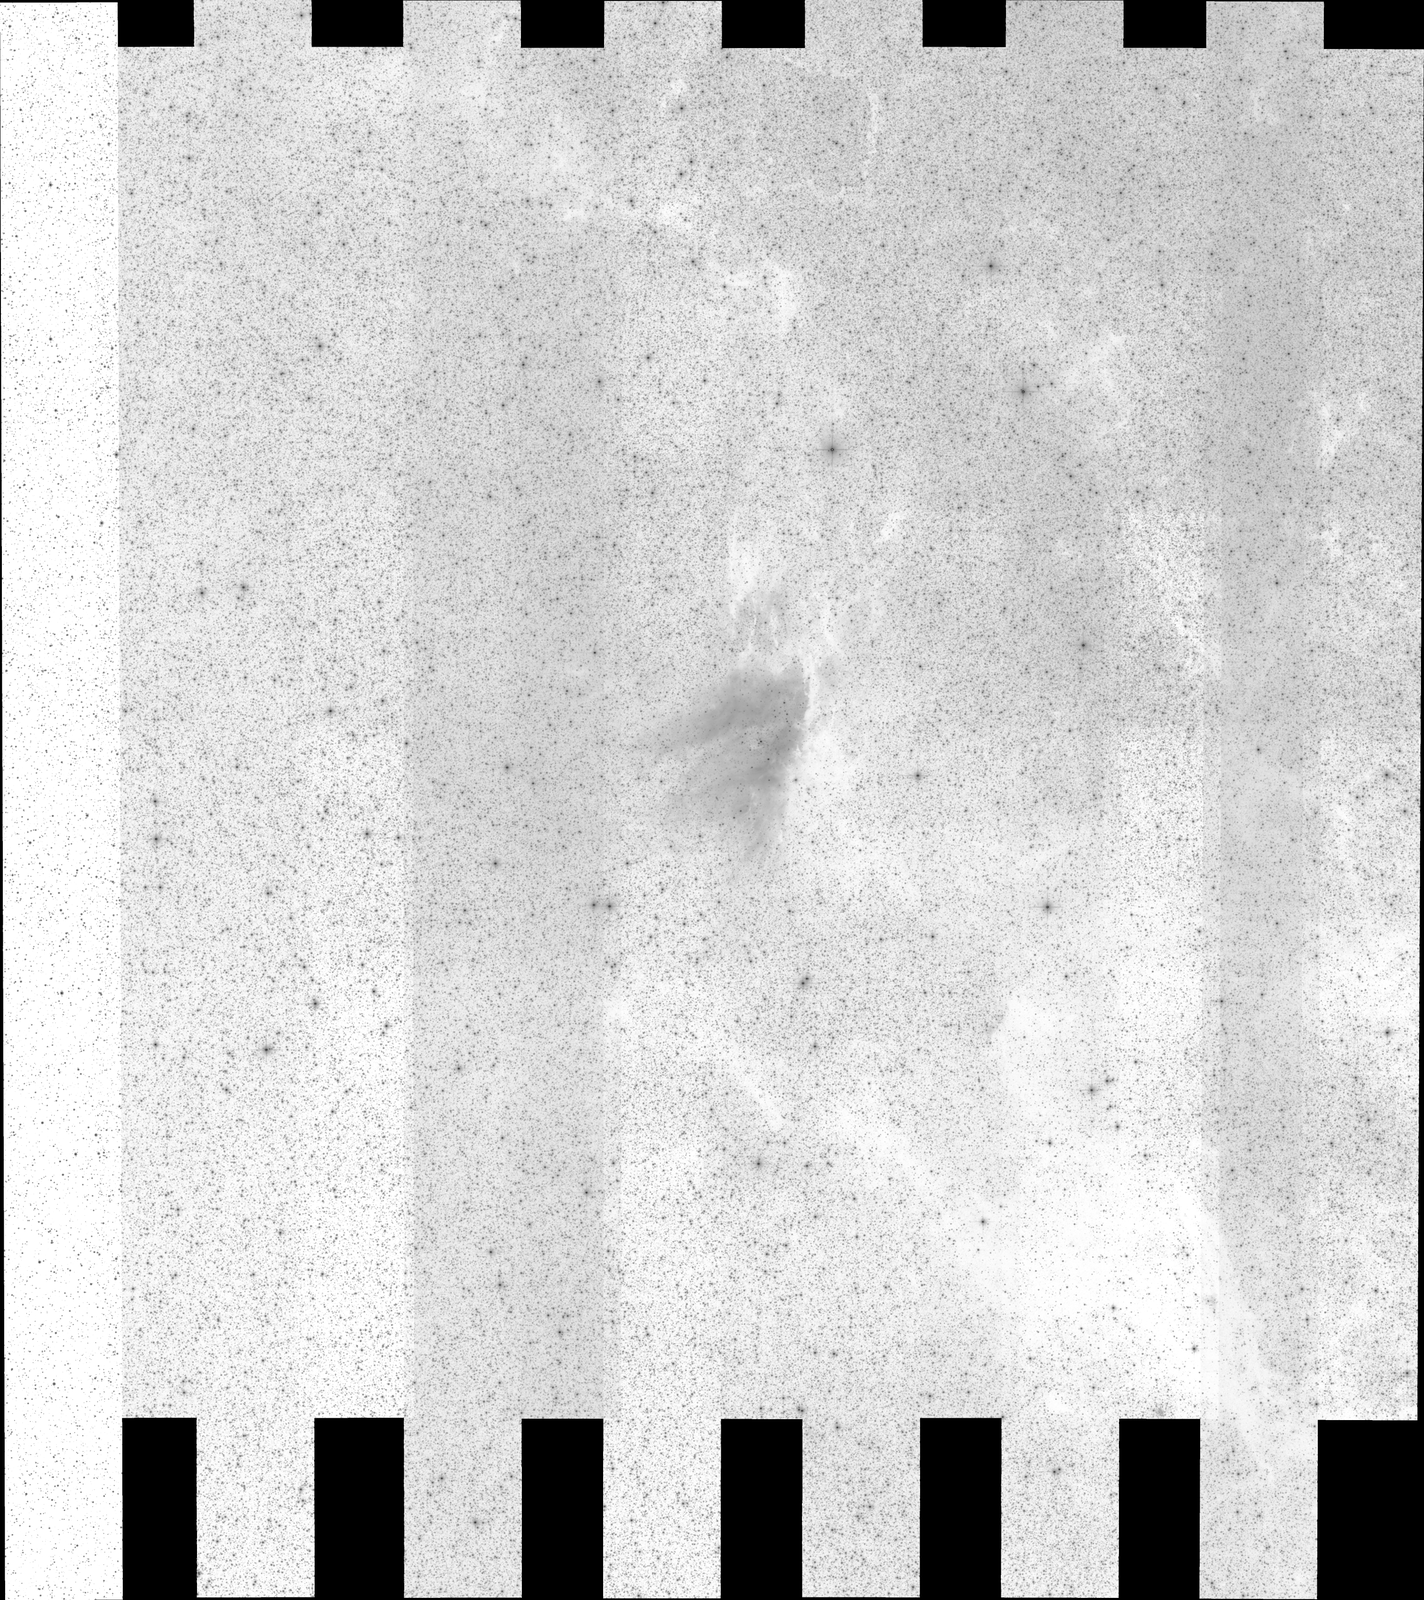

In [6]:
from IPython.display import display
from PIL import Image

def show_preview(pil_img: Image.Image, max_dim: int = 1024) -> Image.Image:
    preview = pil_img.copy()
    preview.thumbnail((max_dim, max_dim), Image.LANCZOS)
    return preview

for uid in uid_set:
    png_file = f"{uid}-m17.png"
    if os.path.exists(png_file):
        with Image.open(png_file) as img:
            preview_img = show_preview(img, max_dim=1600)
            display(preview_img)

## Additional Cleanups

In [9]:
# !rm -f *m17.fits

In [10]:
# !rm -f *.stdout

In [11]:
# !rm -f *.stderr